# Grass growth anomalies

- Weighted means take into account the number of days in each month

In [1]:
# import libraries
from datetime import datetime, timezone
import climag.plot_stats as cstats
import importlib
import xarray as xr
import matplotlib.pyplot as plt
import climag.plot_configs as cplt
import glob
import itertools
import os
import sys
import numpy as np

In [2]:
# season_list = ["DJF", "MAM", "JJA", "SON"]
exp_list = ["historical", "rcp45", "rcp85"]
model_list = ["CNRM-CM5", "EC-EARTH", "HadGEM2-ES", "MPI-ESM-LR"]
dataset_list = ["EURO-CORDEX", "HiResIreland"]
# stat_list = ["mean", "std", "max", "min"]

In [3]:
importlib.reload(cstats)

<module 'climag.plot_stats' from '/run/media/nms/Backup/Documents/Git/ClimAg/ClimAg/climag/plot_stats.py'>

In [4]:
def keep_minimal_vars(data):
    """
    Drop variables that are not needed
    """

    # data = data.assign(prod=data["i_bm"] + data["h_bm"])

    data = data.drop_vars([
        "bm_gv", "bm_gr", "bm_dv", "bm_dr", "age_gv", "age_gr", "age_dv",
        "age_dr", "omd_gv", "omd_gr", "lai", "env", "wr", "aet",
        "sen_gv", "sen_gr", "abs_dv", "abs_dr", "c_bm",
        "bm", "pgro", "i_bm", "h_bm"
    ])

    return data

In [5]:
def combine_datasets(dataset_dict, dataset_crs):
    dataset = xr.combine_by_coords(dataset_dict.values(), combine_attrs="override")
    dataset.rio.write_crs(dataset_crs, inplace=True)

    return dataset

In [6]:
def generate_stats(ensemble=True):
    eurocordex = {}
    eurocordex_lta = {}
    hiresireland = {}
    hiresireland_lta = {}

    for exp, model, dataset in itertools.product(
        exp_list, model_list, dataset_list
    ):
        # auto-rechunking may cause NotImplementedError with object dtype where it
        # will not be able to estimate the size in bytes of object data
        if model == "HadGEM2-ES":
            CHUNKS = 300
        else:
            CHUNKS = "auto"

        ds = xr.open_mfdataset(
            glob.glob(
                os.path.join(
                    "data", "ModVege", dataset, exp, model,
                    f"*{dataset}*{model}*{exp}*.nc"
                )
            ),
            chunks=CHUNKS,
            decode_coords="all"
        )

        if dataset == "EURO-CORDEX":
            crs_eurocordex = ds.rio.crs
        else:
            crs_hiresireland = ds.rio.crs

        # convert HadGEM2-ES data back to 360-day calendar
        # this ensures that the correct weighting is applied when
        # calculating the weighted average
        if model == "HadGEM2-ES":
            ds = ds.convert_calendar("360_day", align_on="year")

        # remove spin-up year
        if exp == "historical":
            ds = ds.sel(time=slice("1976", "2005"))
        else:
            ds = ds.sel(time=slice("2041", "2070"))

        # assign new coordinates and dimensions
        ds = ds.assign_coords(exp=exp)
        ds = ds.expand_dims(dim="exp")
        ds = ds.assign_coords(model=model)
        ds = ds.expand_dims(dim="model")

        # drop unnecessary variables
        ds = keep_minimal_vars(data=ds)

        # weighted mean growth
        ds_1 = ds.copy()
        # calculate the weights by grouping month length by season
        weights = (
            ds_1["time"].dt.days_in_month.groupby("time.year") /
            ds_1["time"].dt.days_in_month.groupby("time.year").sum()
        )
        # test that the sum of weights for each season is one
        np.testing.assert_allclose(
            weights.groupby("time.year").sum().values,
            np.ones(len(set(weights["year"].values)))
        )
        # calculate the weighted average
        ds_1 = (
            (ds_1 * weights).groupby("time.year").sum(dim="time")
        )
        if ensemble:
            ds_1 = ds_1.mean(dim="model", skipna=True)

        # long-term average
        if ensemble:
            ds_2 = ds.mean(dim=["time", "model"], skipna=True)
        else:
            ds_2 = ds.mean(dim="time", skipna=True)

        if dataset == "EURO-CORDEX":
            eurocordex[f"{dataset}_{model}_{exp}"] = ds_1.copy()
            eurocordex_lta[f"{dataset}_{model}_{exp}"] = ds_2.copy()
        else:
            hiresireland[f"{dataset}_{model}_{exp}"] = ds_1.copy()
            hiresireland_lta[f"{dataset}_{model}_{exp}"] = ds_2.copy()

    eurocordex = combine_datasets(eurocordex, crs_eurocordex)
    hiresireland = combine_datasets(hiresireland, crs_hiresireland)
    eurocordex_lta = combine_datasets(eurocordex_lta, crs_eurocordex)
    hiresireland_lta = combine_datasets(hiresireland_lta, crs_hiresireland)

    return eurocordex, hiresireland, eurocordex_lta, hiresireland_lta

In [7]:
# def plot_diff(data, lta, levels):
#     for exp in exp_list:
#         data_plot = data - lta
#         data_plot = data_plot.sel(exp=exp)
#         if exp == "historical":
#             data_plot = data_plot.sel(year=slice("1976", "2005"))
#         else:
#             data_plot = data_plot.sel(year=slice("2041", "2070"))
#         print(exp)
#         fig = data_plot["gro"].plot.contourf(
#             x="rlon", y="rlat", col="year", col_wrap=5,
#             cmap="BrBG", extend="both", robust=True,
#             # levels=cstats.colorbar_levels(levels),
#             subplot_kws={"projection": cplt.plot_projection},
#             transform=cplt.rotated_pole_transform(data),
#             xlim=(-1.775, 1.6),
#             ylim=(-2.1, 2.1),
#             # figsize=(12, 9.25),
#             cbar_kwargs = {
#                 "label": "Anomaly [kg DM ha⁻¹ day⁻¹]",
#                 "aspect": 30,
#                 "location": "bottom",
#                 "fraction": 0.085,
#                 "shrink": 0.85,
#                 "pad": 0.05,
#                 "extendfrac": "auto",
#                 # "ticks": cstats.colorbar_ticks(levels)
#             }
#         )
#         for axis in fig.axs.flat:
#             cstats.ie_bbox.to_crs(cplt.plot_projection).plot(
#                 ax=axis, edgecolor="darkslategrey", color="white",
#                 linewidth=.5
#             )
#         fig.set_titles("{value}", weight="semibold", fontsize=14)
#         plt.show()

In [8]:
# def calculate_diff(data):
#     data_out = xr.combine_by_coords([
#         (
#             data.sel(exp="rcp45") - data.sel(exp="historical")
#         ).assign_coords(exp="rcp45 - historical").expand_dims(dim="exp"),
#         (
#             data.sel(exp="rcp85") - data.sel(exp="historical")
#         ).assign_coords(exp="rcp85 - historical").expand_dims(dim="exp")
#     ])
#     return data_out

## Mean growth

In [9]:
eurocordex, hiresireland, eurocordex_lta, hiresireland_lta = generate_stats()
# eurocordex_diff = calculate_diff(eurocordex)
# hiresireland_diff = calculate_diff(hiresireland)

In [33]:
eurocordex

<xarray.Dataset>
Dimensions:      (rlat: 33, rlon: 37, exp: 2, model: 4, year: 30)
Coordinates:
    lat          (rlat, rlon) float64 dask.array<chunksize=(33, 37), meta=np.ndarray>
    lon          (rlat, rlon) float64 dask.array<chunksize=(33, 37), meta=np.ndarray>
  * rlat         (rlat) float64 3.685 3.795 3.905 4.015 ... 6.985 7.095 7.205
  * rlon         (rlon) float64 -17.27 -17.16 -17.05 ... -13.53 -13.41 -13.3
  * exp          (exp) <U5 'rcp45' 'rcp85'
  * model        (model) <U10 'CNRM-CM5' 'EC-EARTH' 'HadGEM2-ES' 'MPI-ESM-LR'
  * year         (year) int64 2041 2042 2043 2044 2045 ... 2067 2068 2069 2070
    spatial_ref  int64 0
Data variables:
    gro          (year, model, exp, rlat, rlon) float64 dask.array<chunksize=(1, 1, 1, 33, 37), meta=np.ndarray>

In [34]:
eurocordex_lta

<xarray.Dataset>
Dimensions:       (rlat: 33, rlon: 37, model: 4, exp: 2)
Coordinates:
    lat           (rlat, rlon) float64 dask.array<chunksize=(33, 37), meta=np.ndarray>
    lon           (rlat, rlon) float64 dask.array<chunksize=(33, 37), meta=np.ndarray>
  * rlat          (rlat) float64 3.685 3.795 3.905 4.015 ... 6.985 7.095 7.205
  * rlon          (rlon) float64 -17.27 -17.16 -17.05 ... -13.53 -13.41 -13.3
    height        float64 2.0
    rotated_pole  |S1 b''
  * exp           (exp) <U5 'rcp45' 'rcp85'
  * model         (model) <U10 'CNRM-CM5' 'EC-EARTH' 'HadGEM2-ES' 'MPI-ESM-LR'
    spatial_ref   int64 0
Data variables:
    gro           (model, exp, rlat, rlon) float32 dask.array<chunksize=(1, 1, 33, 37), meta=np.ndarray>

In [10]:
eurocordex_diff = eurocordex - eurocordex_lta

In [11]:
hiresireland_diff = hiresireland - hiresireland_lta

In [38]:
eurocordex_diff

<xarray.Dataset>
Dimensions:       (rlat: 33, rlon: 37, exp: 2, model: 4, year: 30)
Coordinates:
    lat           (rlat, rlon) float64 51.14 51.18 51.22 ... 55.72 55.76 55.79
    lon           (rlat, rlon) float64 -10.17 -10.0 -9.839 ... -6.146 -5.962
  * rlat          (rlat) float64 3.685 3.795 3.905 4.015 ... 6.985 7.095 7.205
  * rlon          (rlon) float64 -17.27 -17.16 -17.05 ... -13.53 -13.41 -13.3
  * exp           (exp) <U5 'rcp45' 'rcp85'
  * model         (model) <U10 'CNRM-CM5' 'EC-EARTH' 'HadGEM2-ES' 'MPI-ESM-LR'
  * year          (year) int64 2041 2042 2043 2044 2045 ... 2067 2068 2069 2070
    spatial_ref   int64 0
    height        float64 2.0
    rotated_pole  |S1 b''
Data variables:
    gro           (year, model, exp, rlat, rlon) float64 dask.array<chunksize=(1, 1, 1, 33, 37), meta=np.ndarray>

In [15]:
def plot_diff(data, levels):
    for exp in exp_list:
        print(exp)
        if exp == "historical":
            data_plot = data.sel(year=slice("1976", "2005"))
        else:
            data_plot = data.sel(year=slice("2041", "2070"))
        fig = data_plot.sel(exp=exp)["gro"].plot.contourf(
            x="rlon", y="rlat", col="year", col_wrap=10,
            subplot_kws={"projection": cplt.plot_projection},
            transform=cplt.rotated_pole_transform(data),
            xlim=(-1.775, 1.6),
            ylim=(-2.1, 2.1),
            figsize=(15, 7.25),
            extend="both", robust=True, cmap="BrBG",
            levels=cstats.colorbar_levels(levels),
            cbar_kwargs = {
                "label": "Anomaly [kg DM ha⁻¹ day⁻¹]",
                "aspect": 40,
                "location": "bottom",
                "fraction": 0.085,
                "shrink": 0.85,
                "pad": 0.05,
                "extendfrac": "auto",
                "ticks": cstats.colorbar_ticks(levels)
            }
        )
        for axis in fig.axs.flat:
            cstats.ie_bbox.to_crs(cplt.plot_projection).plot(
                ax=axis, edgecolor="darkslategrey", color="white",
                linewidth=.5
            )
        fig.set_titles("{value}", weight="semibold", fontsize=14)
        plt.show()

historical


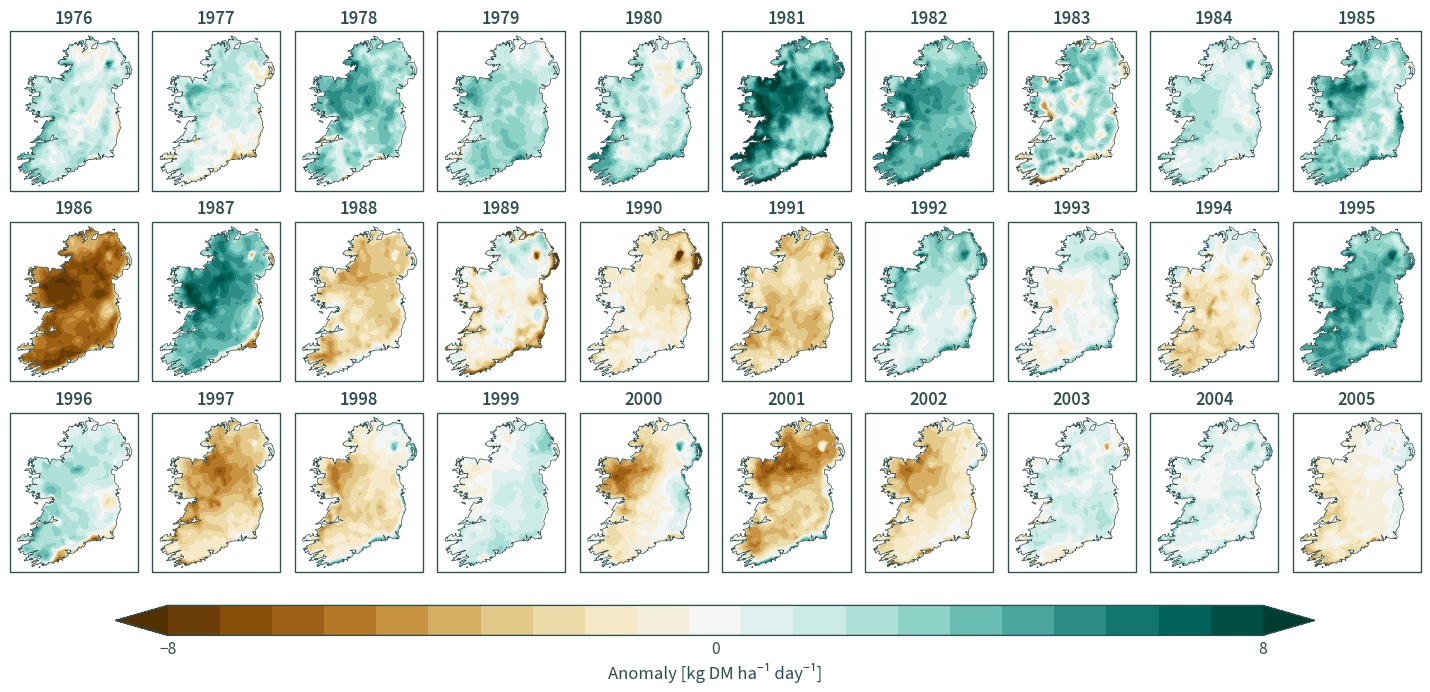

rcp45


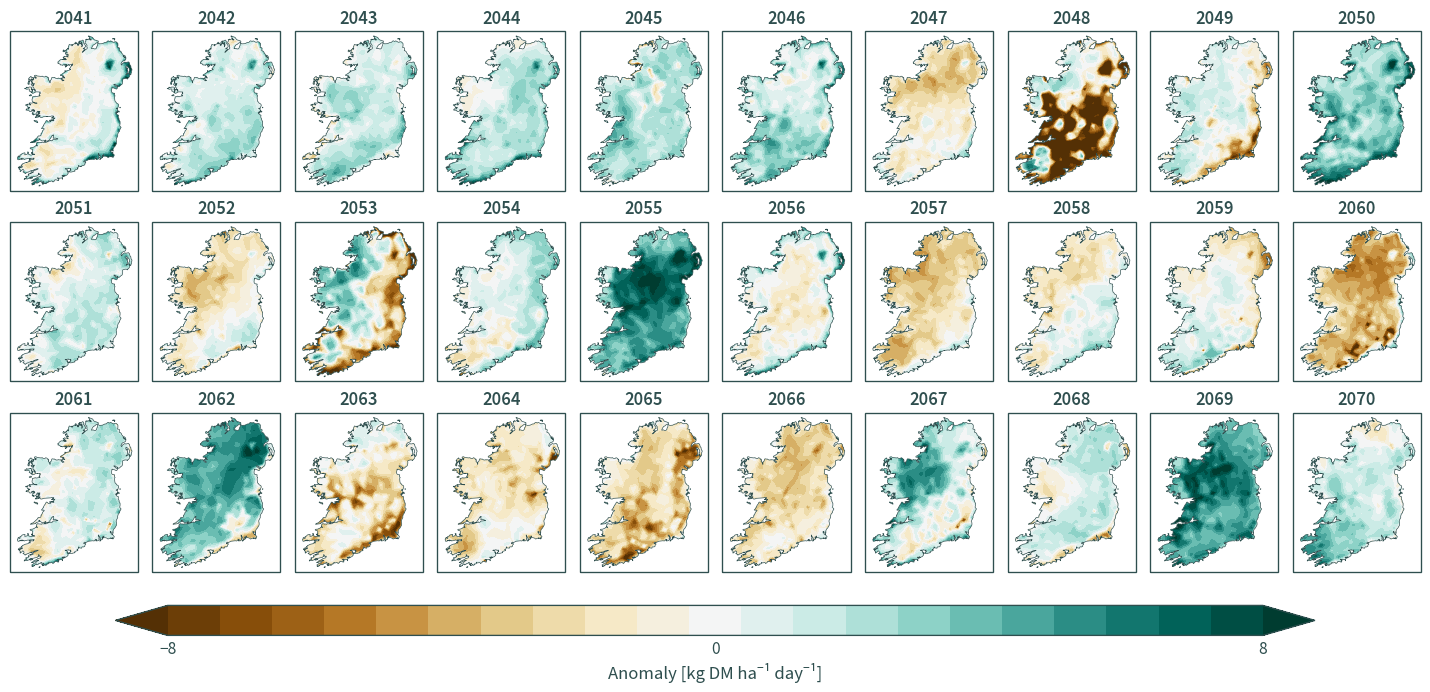

rcp85


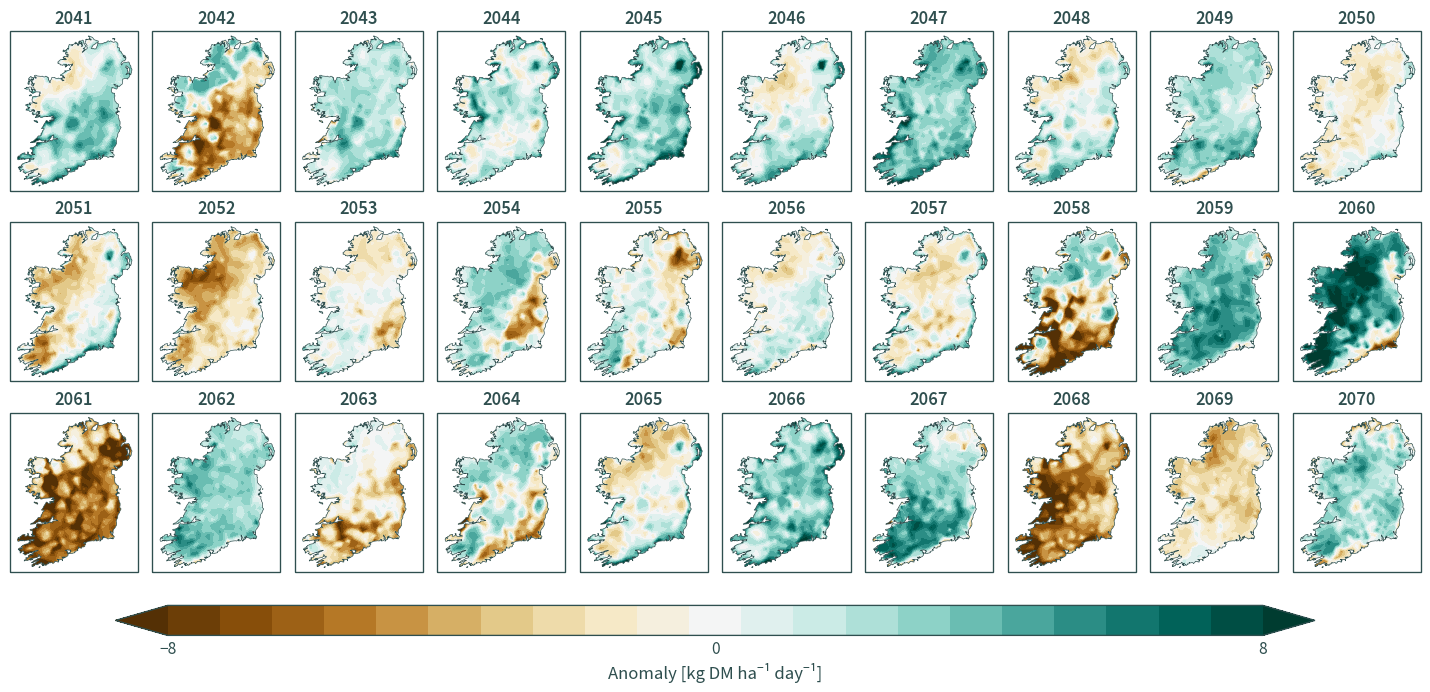

In [16]:
plot_diff(eurocordex_diff, 8)

historical


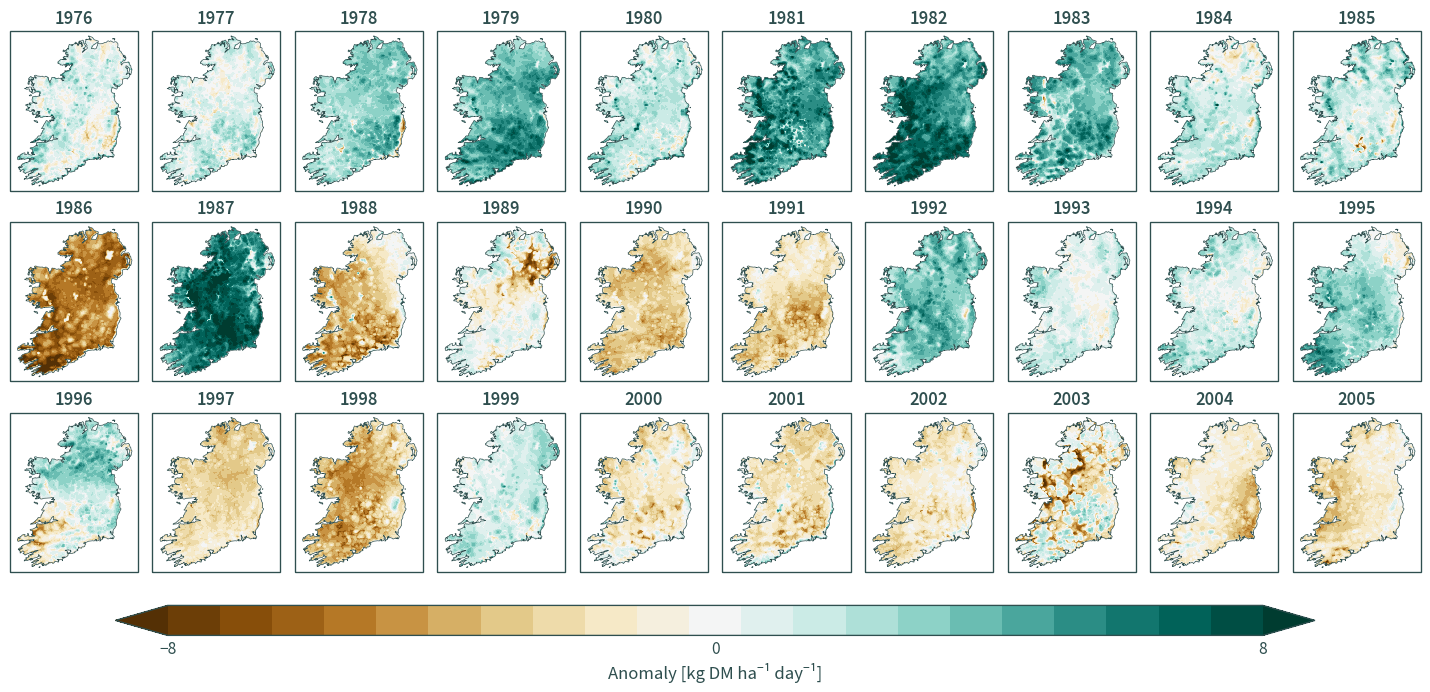

rcp45


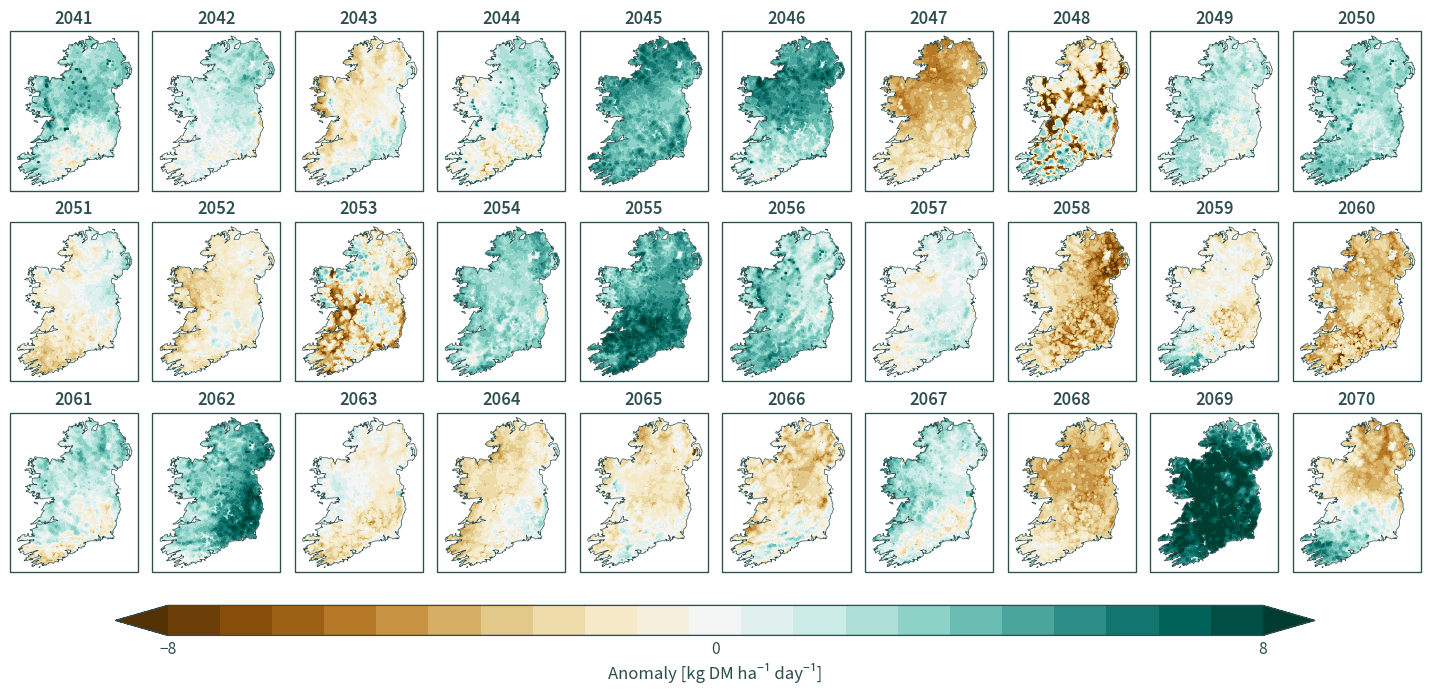

rcp85


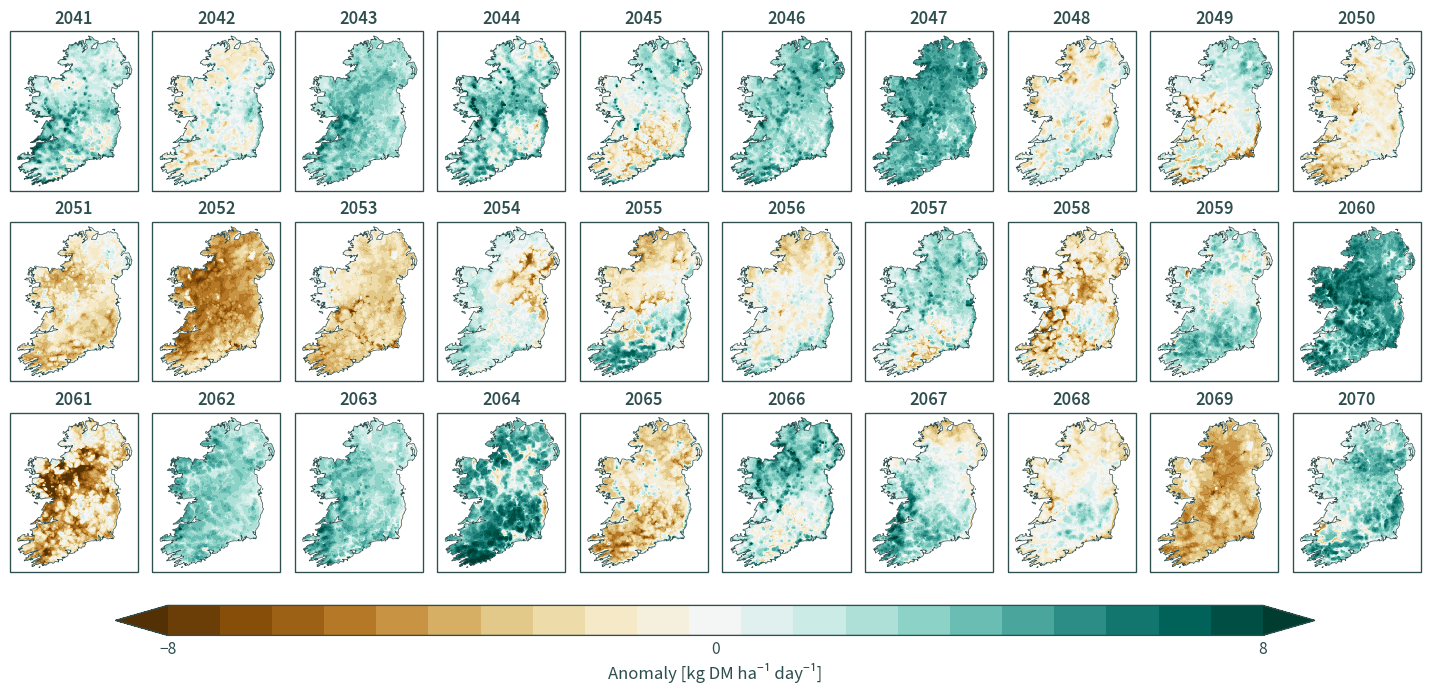

In [17]:
plot_diff(hiresireland_diff, 8)